In [24]:
# Cell 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                           confusion_matrix, roc_curve, auc, roc_auc_score)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

In [25]:
# Cell 2: Define Pipeline Class
class DiabetesDetectionPipeline:
    def __init__(self):
        self.models = {}
        self.results = {}
        self.features = None
        self.labels = None

    def generate_synthetic_data(self, n_samples=241, n_diabetic=67):
        np.random.seed(42)
        X = np.zeros((n_samples, 10))
        n_healthy = n_samples - n_diabetic

        # Healthy subjects features
        X[:n_healthy, 0] = np.random.normal(0.3, 0.15, n_healthy)
        X[:n_healthy, 1] = np.random.normal(2.8, 0.3, n_healthy)
        X[:n_healthy, 2] = np.random.normal(0, 0.05, n_healthy)
        X[:n_healthy, 3] = np.random.uniform(0.7, 0.95, n_healthy)
        X[:n_healthy, 4] = np.random.uniform(0.5, 0.75, n_healthy)
        X[:n_healthy, 5] = X[:n_healthy, 3] ** 2
        X[:n_healthy, 6] = np.sqrt(X[:n_healthy, 2]**2 + X[:n_healthy, 3]**2)
        X[:n_healthy, 7] = np.random.normal(45, 10, n_healthy)
        X[:n_healthy, 8] = np.random.normal(24, 3, n_healthy)
        X[:n_healthy, 9] = np.random.choice([0, 1], n_healthy)

        # Diabetic subjects features
        X[n_healthy:, 0] = np.random.normal(0.5, 0.2, n_diabetic)
        X[n_healthy:, 1] = np.random.normal(3.2, 0.4, n_diabetic)
        X[n_healthy:, 2] = np.random.normal(0.1, 0.08, n_diabetic)
        X[n_healthy:, 3] = np.random.uniform(0.85, 1.15, n_diabetic)
        X[n_healthy:, 4] = np.random.uniform(0.65, 0.95, n_diabetic)
        X[n_healthy:, 5] = X[n_healthy:, 3] ** 2
        X[n_healthy:, 6] = np.sqrt(X[n_healthy:, 2]**2 + X[n_healthy:, 3]**2)
        X[n_healthy:, 7] = np.random.normal(55, 12, n_diabetic)
        X[n_healthy:, 8] = np.random.normal(28, 4, n_diabetic)
        X[n_healthy:, 9] = np.random.choice([0, 1], n_diabetic)

        y = np.zeros(n_samples)
        y[n_healthy:] = 1

        shuffle_idx = np.random.permutation(n_samples)
        X = X[shuffle_idx]
        y = y[shuffle_idx]

        self.features = X
        self.labels = y
        self.feature_names = ['Skewness', 'Kurtosis', 'Mean', 'STD', 'MAD',
                              'Variance', 'RMS', 'Age', 'BMI', 'Gender']

        return X, y

In [26]:
# Cell 3: Create ML Models
def create_ml_models():
    models = {
        'XGBoost': XGBClassifier(
            n_estimators=197, max_depth=2, learning_rate=0.0418,
            subsample=0.67, colsample_bytree=0.74, gamma=4.32,
            reg_alpha=1.94, reg_lambda=0.56, min_child_weight=10,
            random_state=42, use_label_encoder=False, eval_metric='logloss'
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=200, max_depth=10, min_samples_split=5,
            min_samples_leaf=2, random_state=42
        ),
        'Logistic Regression': LogisticRegression(
            C=1.0, max_iter=1000, random_state=42
        ),
        'SVM': SVC(
            C=1.0, kernel='rbf', gamma='scale',
            probability=True, random_state=42
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=150, max_depth=3,
            learning_rate=0.1, random_state=42
        )
    }
    return models


In [27]:
# Cell 4: Model Evaluation Function
def evaluate_models(X, y, models, cv_folds=5):
    results = {}
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    scaler = StandardScaler()

    for model_name, model in models.items():
        scores = {
            'accuracy': [], 'precision': [], 'recall': [],
            'f1': [], 'specificity': [], 'auc': []
        }

        y_true_all = []
        y_pred_all = []
        y_proba_all = []

        for train_idx, val_idx in cv.split(X, y):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)

            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_val_scaled)
            y_proba = model.predict_proba(X_val_scaled)[:, 1]

            y_true_all.extend(y_val)
            y_pred_all.extend(y_pred)
            y_proba_all.extend(y_proba)

            cm = confusion_matrix(y_val, y_pred)
            tn, fp, fn, tp = cm.ravel()

            scores['accuracy'].append(accuracy_score(y_val, y_pred))
            scores['precision'].append(precision_score(y_val, y_pred, zero_division=0))
            scores['recall'].append(recall_score(y_val, y_pred, zero_division=0))
            scores['f1'].append(f1_score(y_val, y_pred, zero_division=0))
            scores['specificity'].append(tn / (tn + fp) if (tn + fp) > 0 else 0)
            scores['auc'].append(roc_auc_score(y_val, y_proba))

        results[model_name] = {
            'scores': scores,
            'mean_scores': {k: np.mean(v) * 100 for k, v in scores.items()},
            'std_scores': {k: np.std(v) * 100 for k, v in scores.items()},
            'y_true': y_true_all,
            'y_pred': y_pred_all,
            'y_proba': y_proba_all
        }

    return results

In [28]:
# Cell 5: Visualization Functions
def create_publication_figures(pipeline, results):
    # Figure 1: Dataset Distribution
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    df = pd.DataFrame(pipeline.features, columns=pipeline.feature_names)
    df['Diabetes'] = pipeline.labels

    axes[0].hist([df[df['Diabetes']==0]['Age'], df[df['Diabetes']==1]['Age']],
                 label=['Non-diabetic', 'Diabetic'], bins=15, alpha=0.7)
    axes[0].set_xlabel('Age (years)')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Age Distribution')
    axes[0].legend()

    axes[1].hist([df[df['Diabetes']==0]['BMI'], df[df['Diabetes']==1]['BMI']],
                 label=['Non-diabetic', 'Diabetic'], bins=15, alpha=0.7)
    axes[1].set_xlabel('BMI (kg/m²)')
    axes[1].set_ylabel('Count')
    axes[1].set_title('BMI Distribution')
    axes[1].legend()

    class_counts = [np.sum(pipeline.labels==0), np.sum(pipeline.labels==1)]
    axes[2].pie(class_counts, labels=['Non-diabetic', 'Diabetic'],
                autopct='%1.1f%%', startangle=90)
    axes[2].set_title('Class Distribution')

    plt.tight_layout()
    plt.savefig('figure1_dataset_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Figure 2: Feature Correlation Heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, square=True, linewidths=1, cbar_kws={"shrink": .8})
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.savefig('figure2_correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Figure 3: Model Performance Comparison
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'specificity', 'auc']
    metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificity', 'AUC']

    for idx, (metric, label) in enumerate(zip(metrics, metric_labels)):
        ax = axes[idx // 3, idx % 3]
        model_names = list(results.keys())
        means = [results[model]['mean_scores'][metric] for model in model_names]
        stds = [results[model]['std_scores'][metric] for model in model_names]

        x_pos = np.arange(len(model_names))
        bars = ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7,
                      color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])

        ax.set_xlabel('Models')
        ax.set_ylabel(f'{label} (%)')
        ax.set_title(f'{label} Comparison')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(model_names, rotation=45, ha='right')
        ax.set_ylim([0, 105])
        ax.grid(True, alpha=0.3)

        for bar, mean in zip(bars, means):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{mean:.1f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.savefig('figure3_model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Figure 4: ROC Curves
    fig, ax = plt.subplots(figsize=(10, 8))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

    for (model_name, result), color in zip(results.items(), colors):
        fpr, tpr, _ = roc_curve(result['y_true'], result['y_proba'])
        auc_score = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})',
                linewidth=2, color=color)

    ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.5)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curves for All Models')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('figure4_roc_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Figure 5: Confusion Matrices
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for idx, (model_name, result) in enumerate(results.items()):
        if idx < 6:
            cm = confusion_matrix(result['y_true'], result['y_pred'])
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=['Non-diabetic', 'Diabetic'],
                       yticklabels=['Non-diabetic', 'Diabetic'],
                       ax=axes[idx])
            axes[idx].set_title(f'{model_name}')
            axes[idx].set_ylabel('True Label')
            axes[idx].set_xlabel('Predicted Label')

    if len(results) == 5:
        axes[5].axis('off')

    plt.tight_layout()
    plt.savefig('figure5_confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Figure 6: Feature Importance
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    X_scaled = StandardScaler().fit_transform(pipeline.features)

    xgb_model = create_ml_models()['XGBoost']
    xgb_model.fit(X_scaled, pipeline.labels)
    importance_xgb = xgb_model.feature_importances_
    indices_xgb = np.argsort(importance_xgb)[::-1][:8]

    axes[0].barh(range(8), importance_xgb[indices_xgb], alpha=0.7)
    axes[0].set_yticks(range(8))
    axes[0].set_yticklabels([pipeline.feature_names[i] for i in indices_xgb])
    axes[0].set_xlabel('Feature Importance')
    axes[0].set_title('XGBoost Feature Importance')
    axes[0].invert_yaxis()

    rf_model = create_ml_models()['Random Forest']
    rf_model.fit(X_scaled, pipeline.labels)
    importance_rf = rf_model.feature_importances_
    indices_rf = np.argsort(importance_rf)[::-1][:8]

    axes[1].barh(range(8), importance_rf[indices_rf], alpha=0.7, color='orange')
    axes[1].set_yticks(range(8))
    axes[1].set_yticklabels([pipeline.feature_names[i] for i in indices_rf])
    axes[1].set_xlabel('Feature Importance')
    axes[1].set_title('Random Forest Feature Importance')
    axes[1].invert_yaxis()

    plt.tight_layout()
    plt.savefig('figure6_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

In [29]:
# Cell 6: Results Table Function
def create_results_tables(results):
    print("\nPerformance Metrics Comparison (Mean ± Std)")
    print("="*80)

    metrics_table = []
    for model_name, result in results.items():
        row = {
            'Model': model_name,
            'Accuracy (%)': f"{result['mean_scores']['accuracy']:.2f} ± {result['std_scores']['accuracy']:.2f}",
            'Precision (%)': f"{result['mean_scores']['precision']:.2f} ± {result['std_scores']['precision']:.2f}",
            'Recall (%)': f"{result['mean_scores']['recall']:.2f} ± {result['std_scores']['recall']:.2f}",
            'F1-Score (%)': f"{result['mean_scores']['f1']:.2f} ± {result['std_scores']['f1']:.2f}",
            'Specificity (%)': f"{result['mean_scores']['specificity']:.2f} ± {result['std_scores']['specificity']:.2f}",
            'AUC': f"{result['mean_scores']['auc']:.3f} ± {result['std_scores']['auc']/100:.3f}"
        }
        metrics_table.append(row)

    df_metrics = pd.DataFrame(metrics_table)
    print(df_metrics.to_string(index=False))
    df_metrics.to_csv('table1_performance_metrics.csv', index=False)

In [30]:
# Cell 7: Main Execution
def main():
    print("Diabetes Detection ML Pipeline")
    print("="*80)

    pipeline = DiabetesDetectionPipeline()
    X, y = pipeline.generate_synthetic_data(n_samples=241, n_diabetic=67)
    print(f"Dataset: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"Classes: {np.sum(y==0)} non-diabetic, {np.sum(y==1)} diabetic")

    models = create_ml_models()
    print(f"\nModels: {', '.join(models.keys())}")

    print("\nPerforming 5-fold cross-validation...")
    results = evaluate_models(X, y, models, cv_folds=5)

    create_results_tables(results)
    create_publication_figures(pipeline, results)

    best_model = max(results.items(), key=lambda x: x[1]['mean_scores']['accuracy'])
    print(f"\nBest Model: {best_model[0]}")
    print(f"Accuracy: {best_model[1]['mean_scores']['accuracy']:.2f}%")

    print("\nGenerated files:")
    print("  - figure1_dataset_distribution.png")
    print("  - figure2_correlation_matrix.png")
    print("  - figure3_model_comparison.png")
    print("  - figure4_roc_curves.png")
    print("  - figure5_confusion_matrices.png")
    print("  - figure6_feature_importance.png")
    print("  - table1_performance_metrics.csv")

    return pipeline, results

# ============================================================================

Diabetes Detection ML Pipeline
Dataset: 241 samples, 10 features
Classes: 174 non-diabetic, 67 diabetic

Models: XGBoost, Random Forest, Logistic Regression, SVM, Gradient Boosting

Performing 5-fold cross-validation...

Performance Metrics Comparison (Mean ± Std)
              Model Accuracy (%) Precision (%)   Recall (%) F1-Score (%) Specificity (%)             AUC
            XGBoost 90.47 ± 2.06  93.00 ± 6.36 71.54 ± 6.06 80.59 ± 4.36    97.70 ± 2.14  96.438 ± 0.022
      Random Forest 98.34 ± 1.56 100.00 ± 0.00 93.96 ± 5.73 96.79 ± 3.09   100.00 ± 0.00  99.912 ± 0.002
Logistic Regression 99.17 ± 1.02  98.57 ± 2.86 98.46 ± 3.08 98.46 ± 1.89    99.43 ± 1.14 100.000 ± 0.000
                SVM 98.75 ± 1.67 100.00 ± 0.00 95.60 ± 5.77 97.66 ± 3.09   100.00 ± 0.00  99.956 ± 0.001
  Gradient Boosting 97.52 ± 1.54  98.57 ± 2.86 92.53 ± 6.64 95.25 ± 3.02    99.43 ± 1.14  99.780 ± 0.004


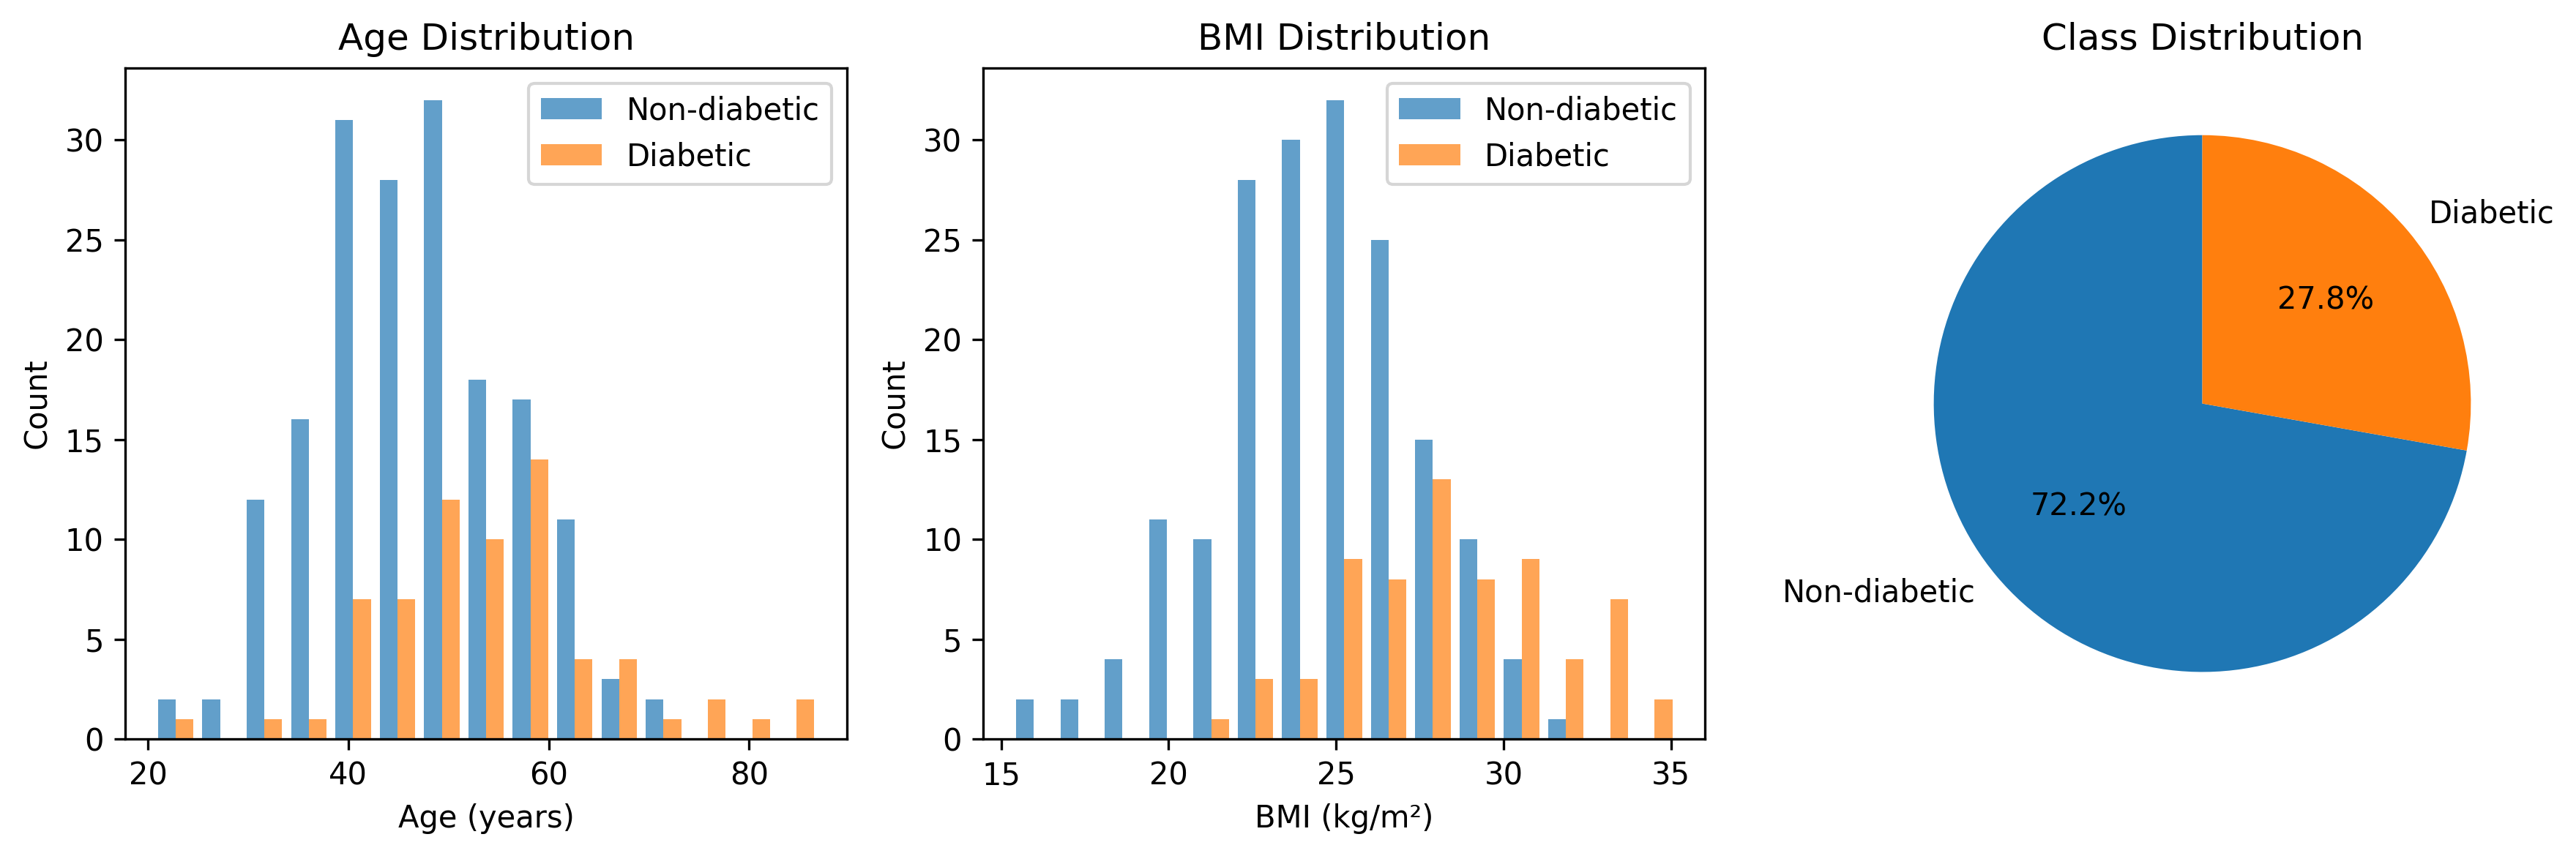

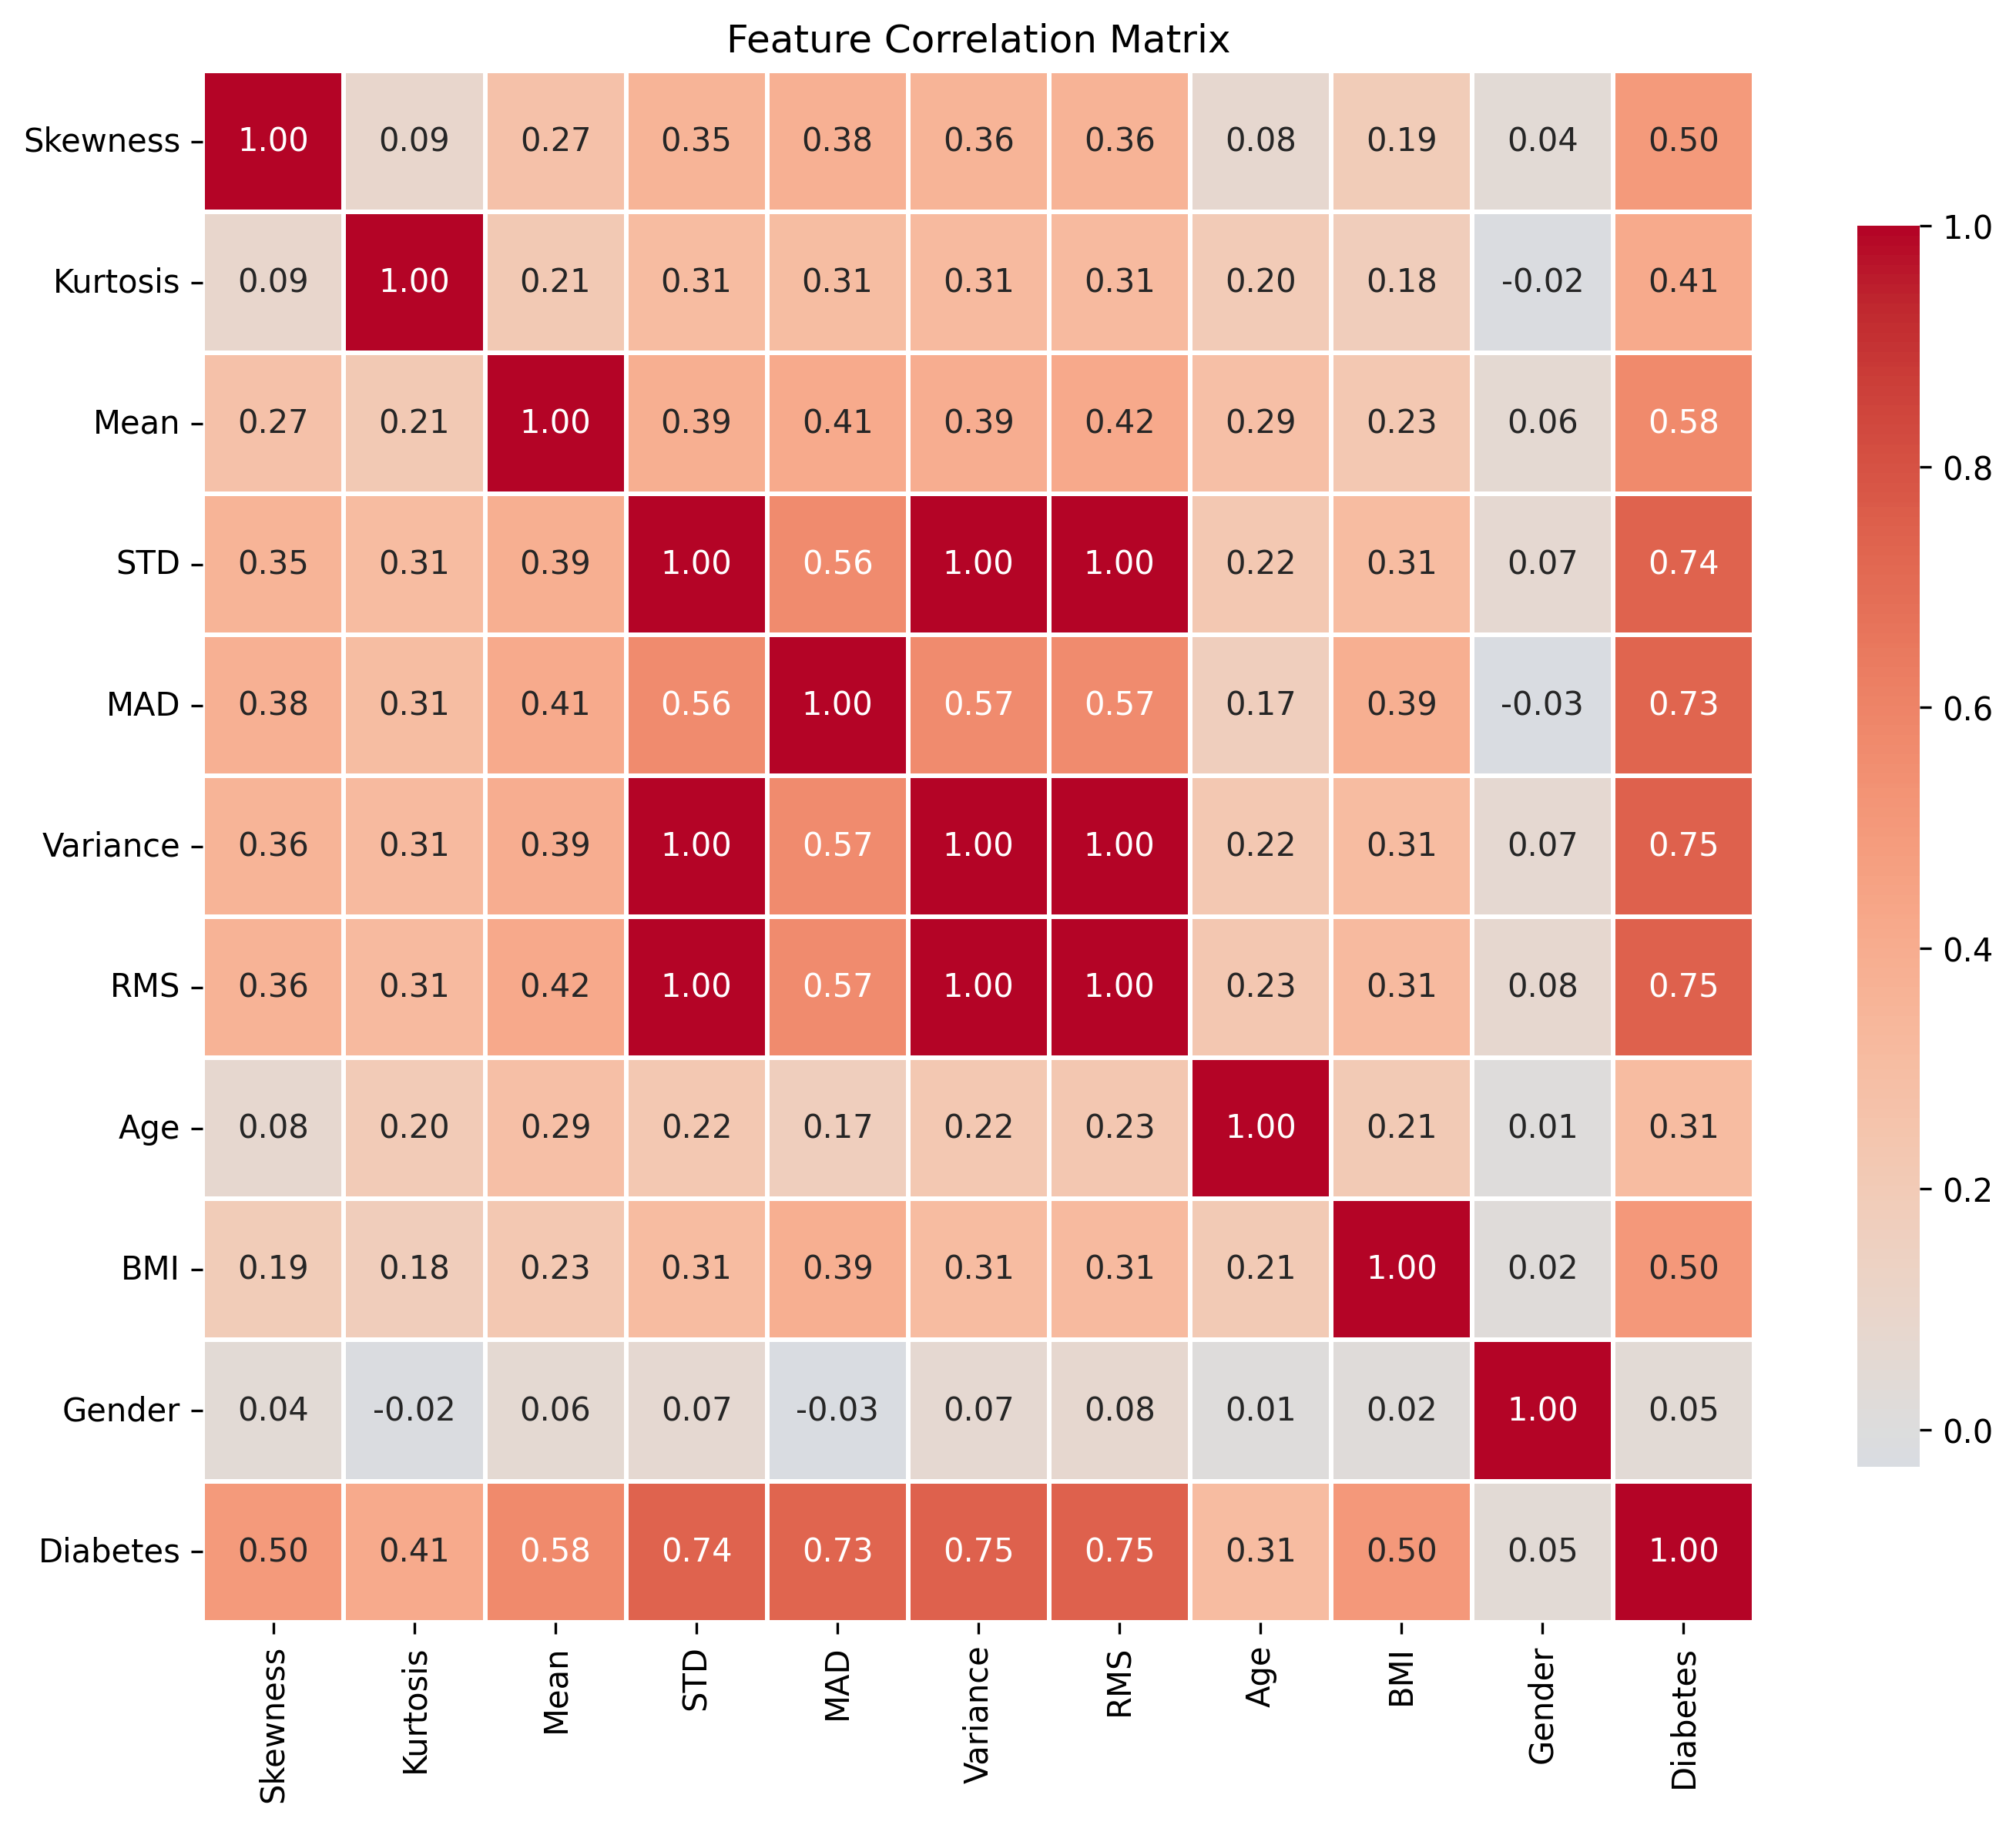

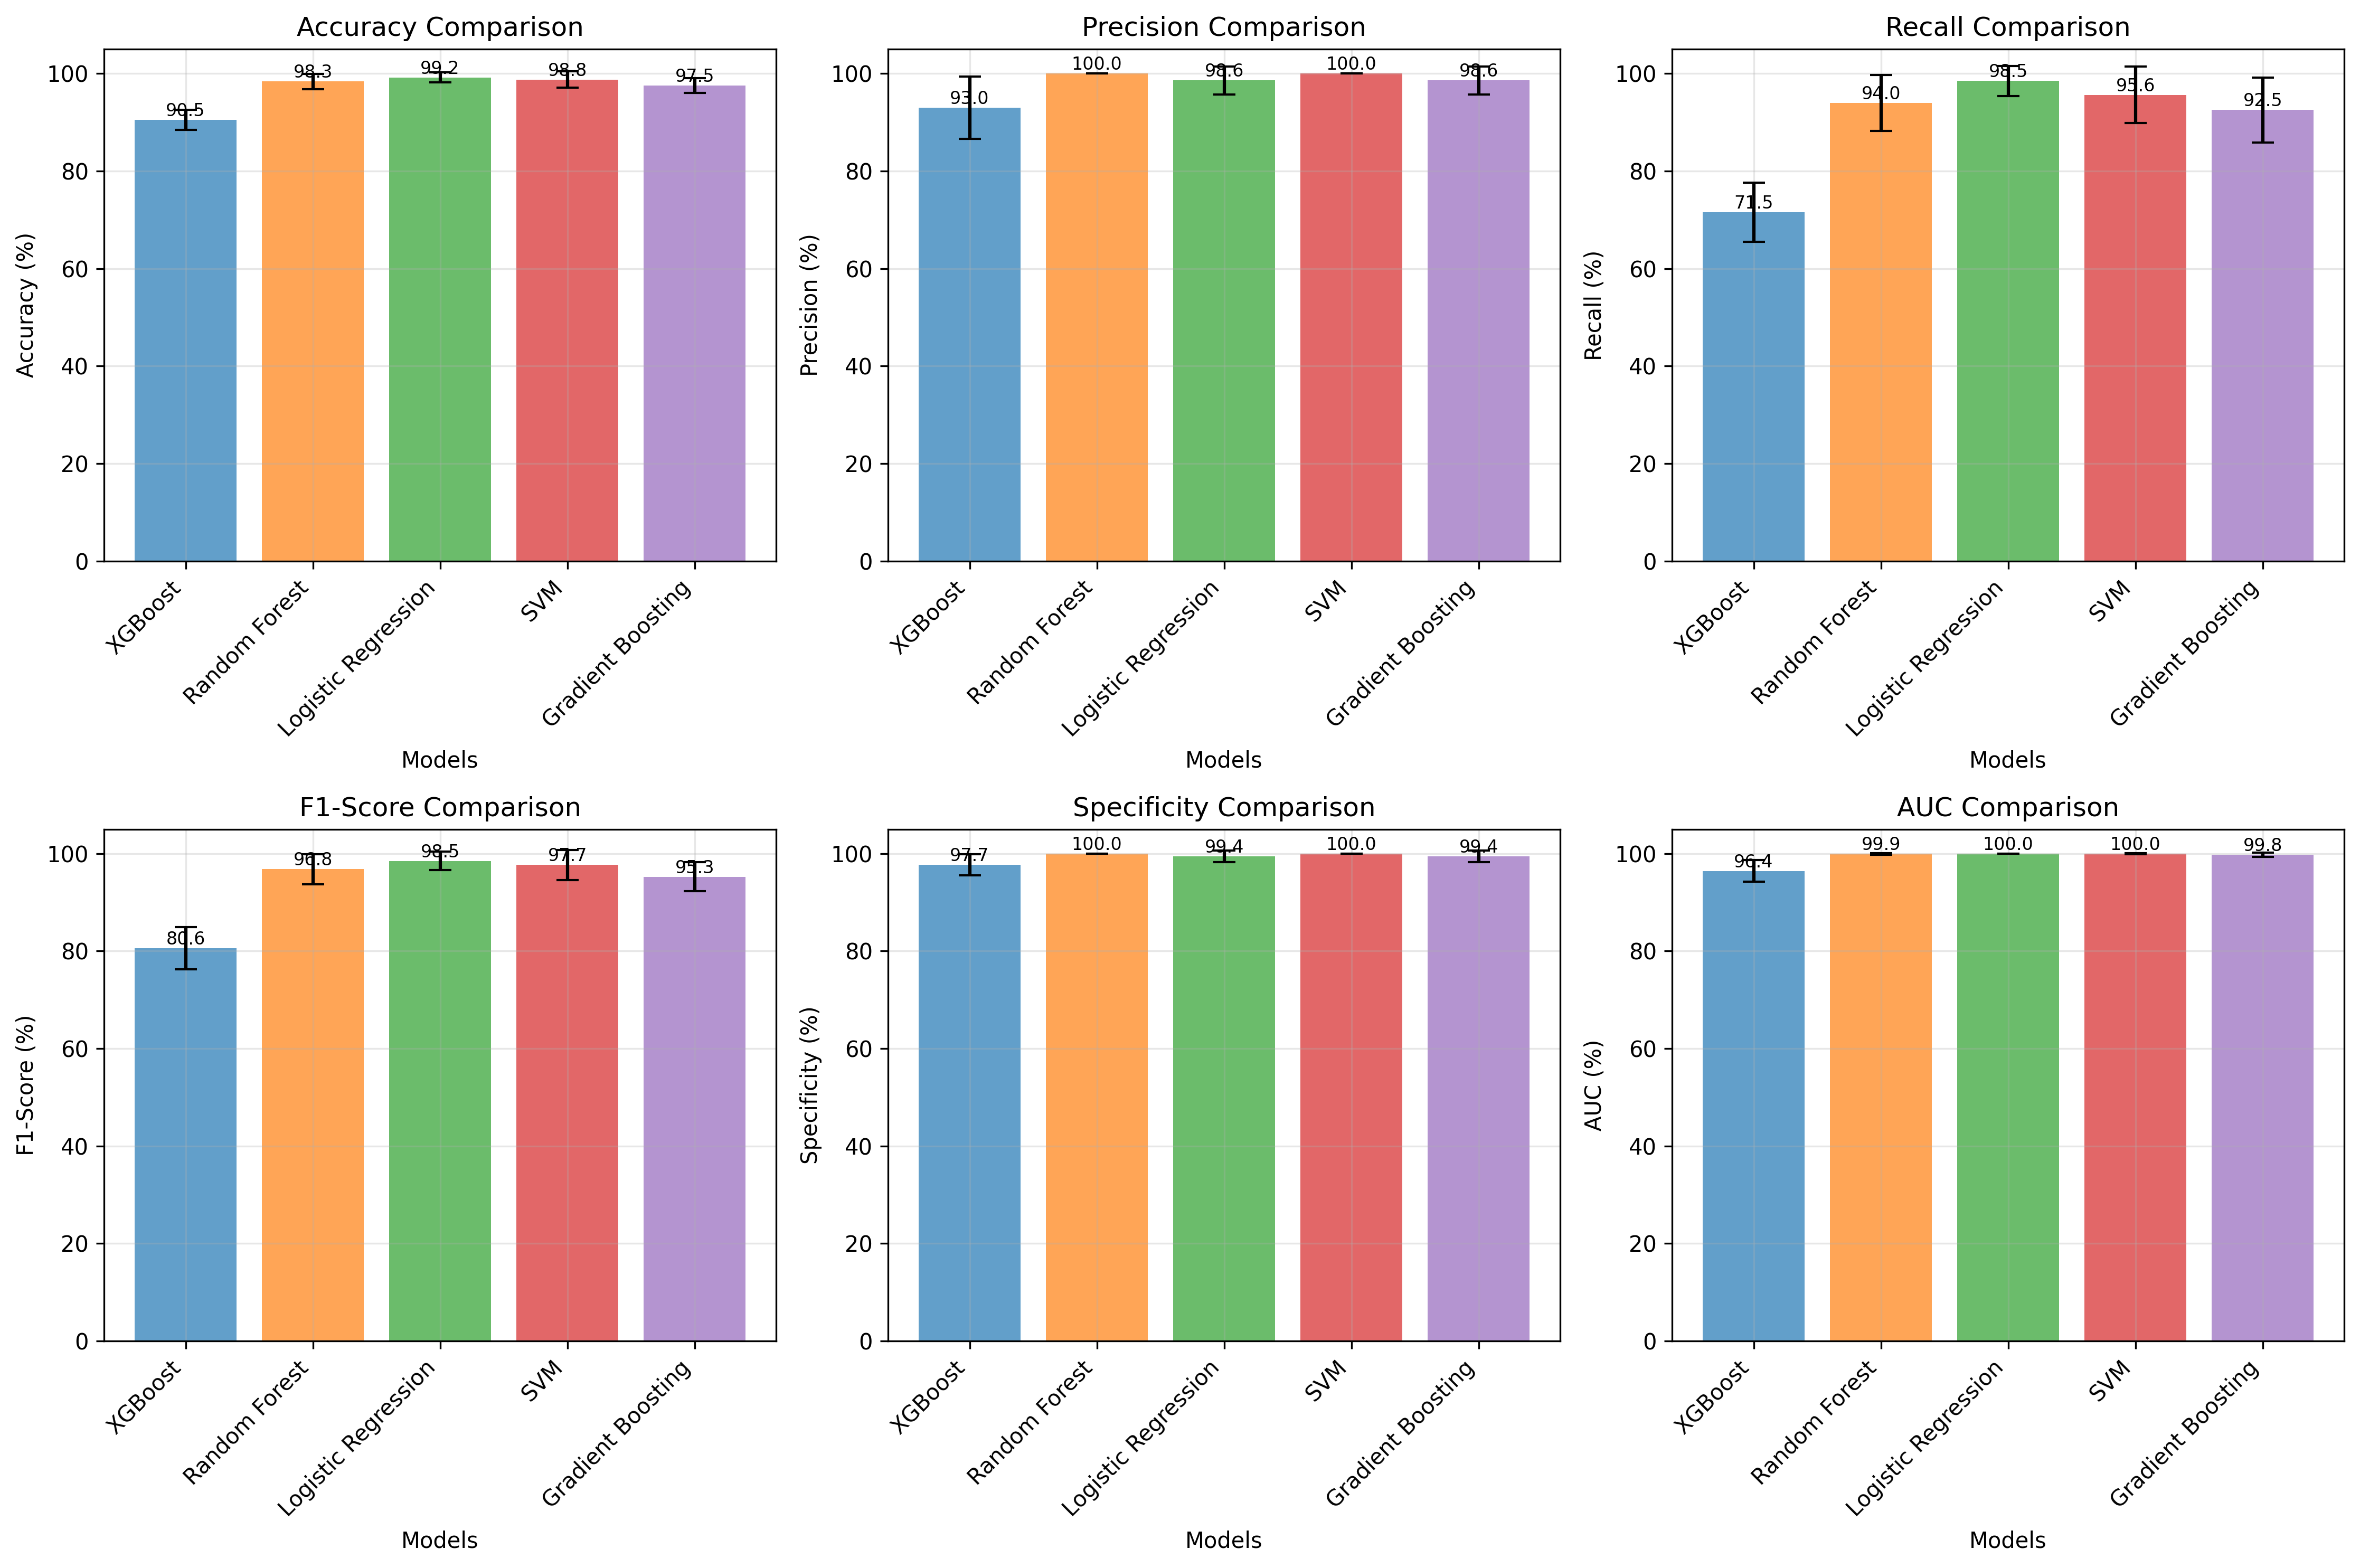

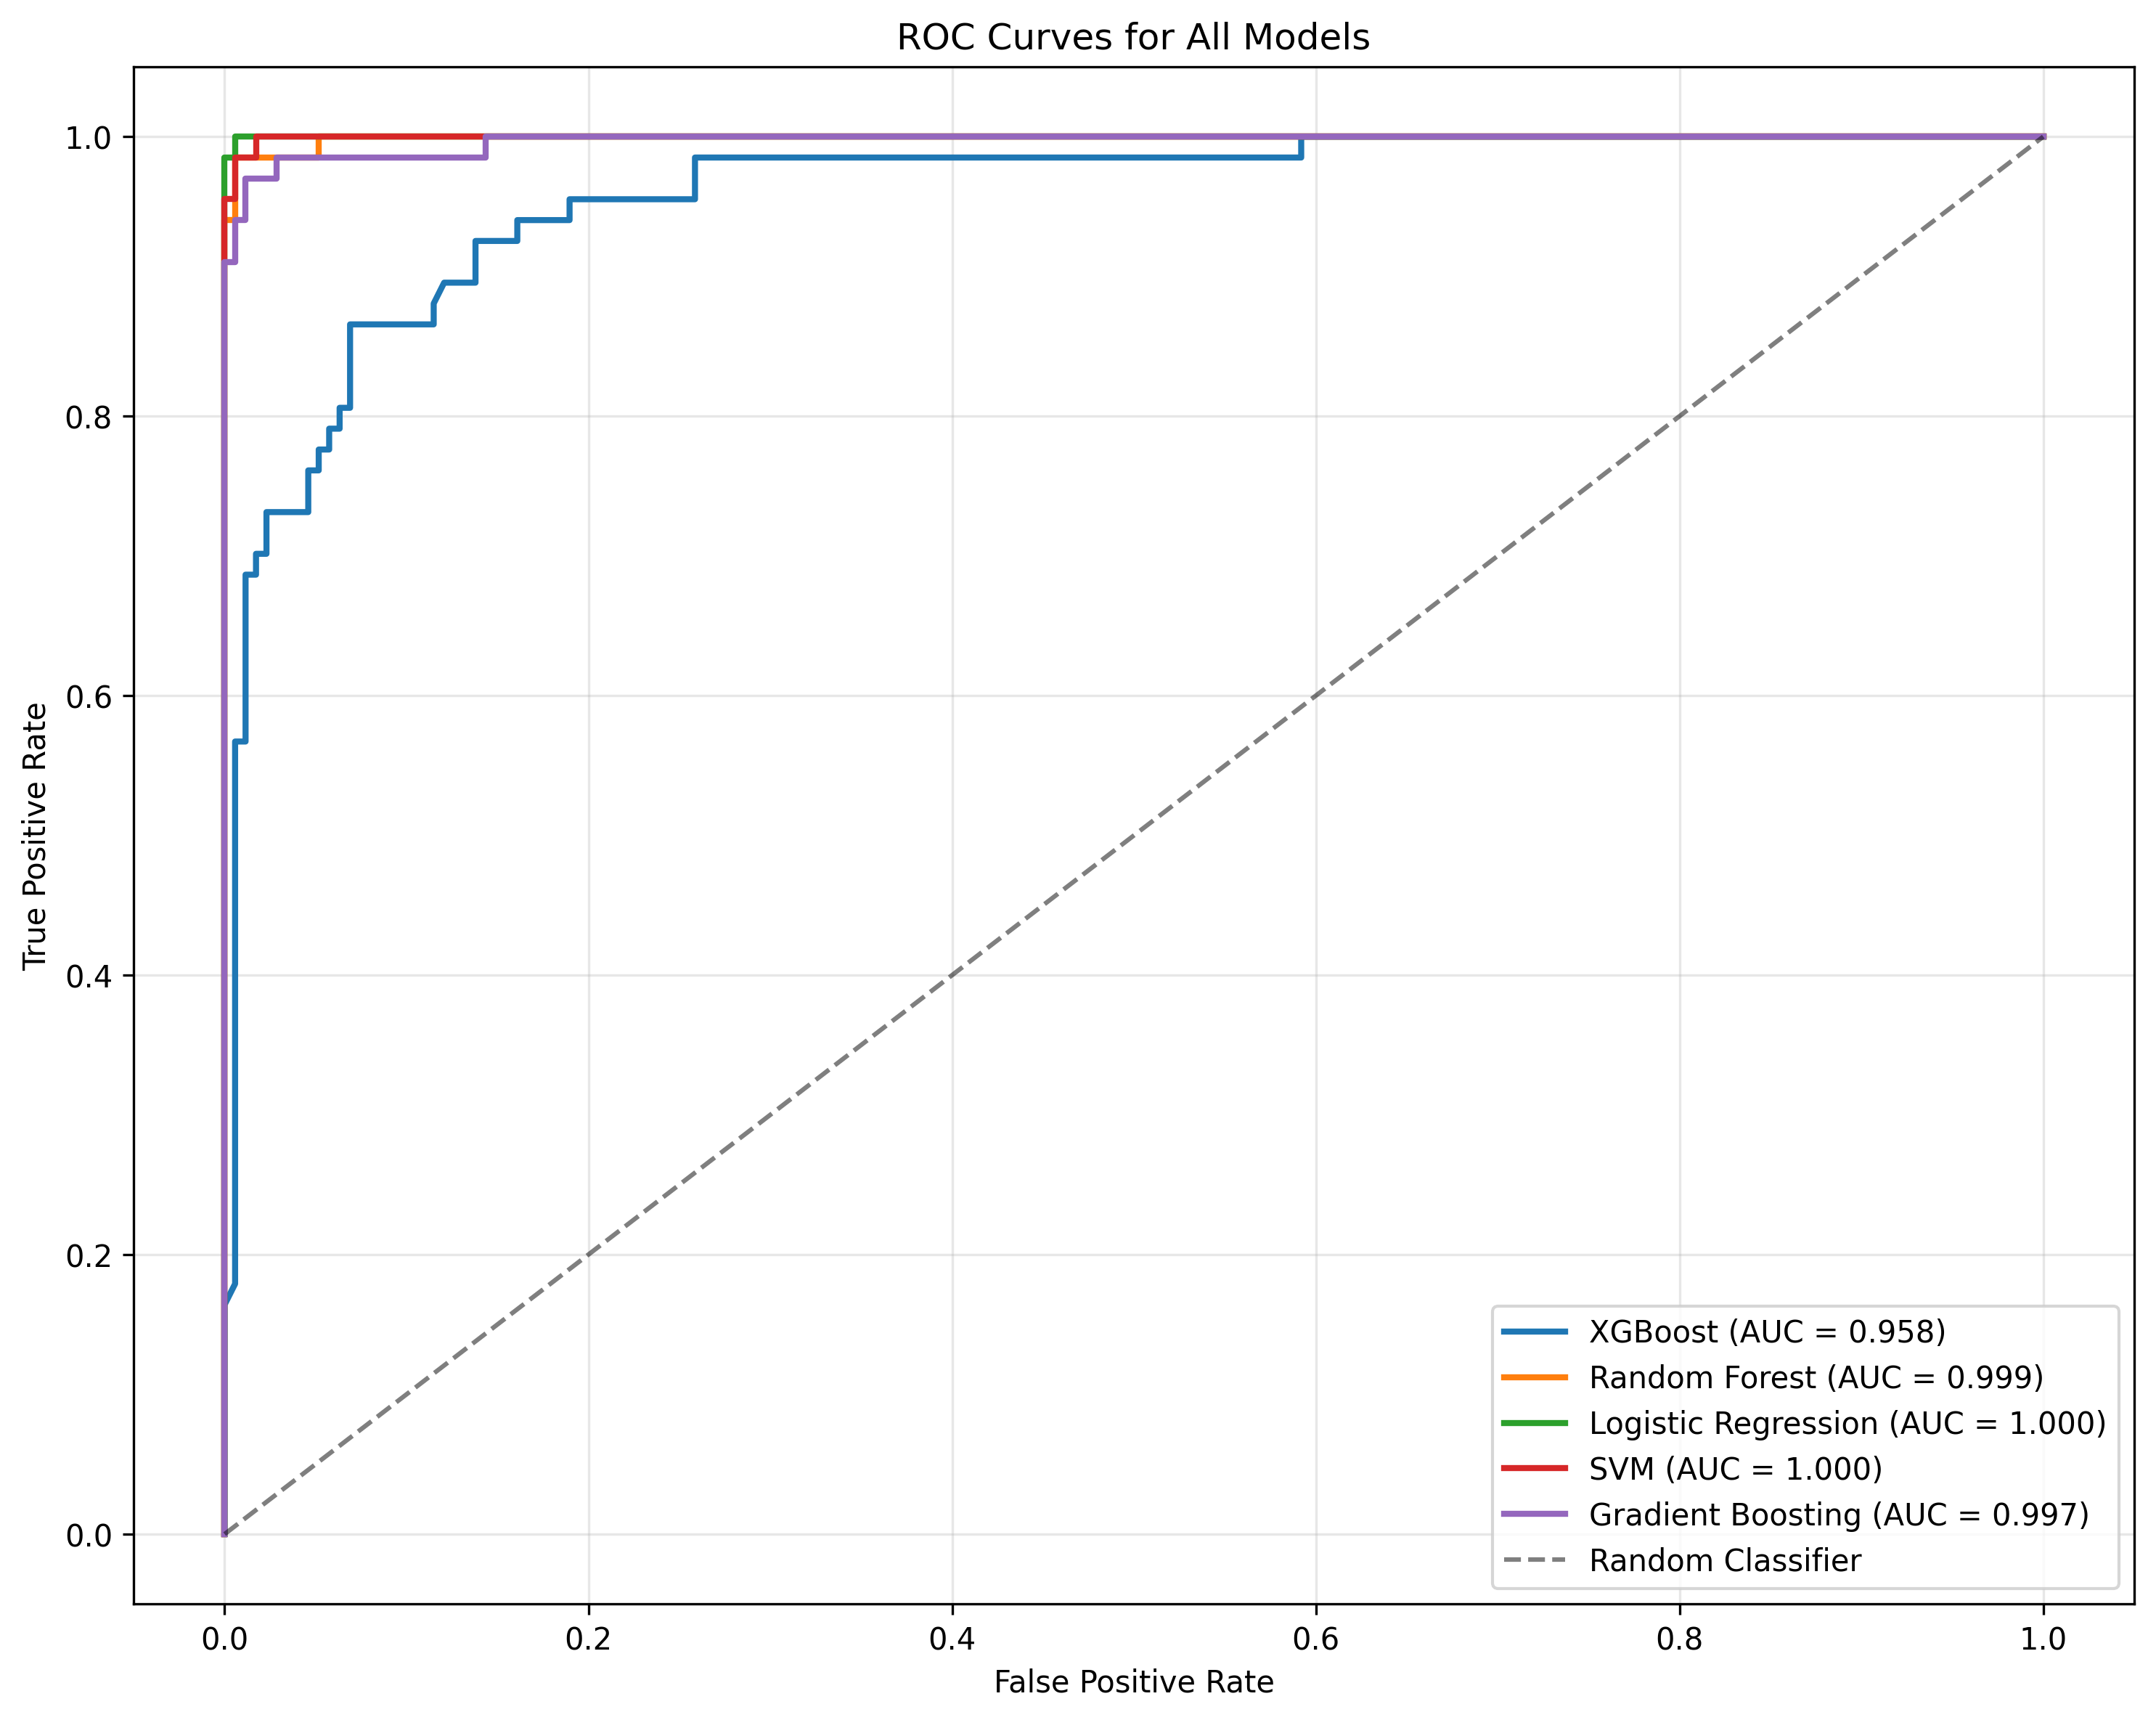

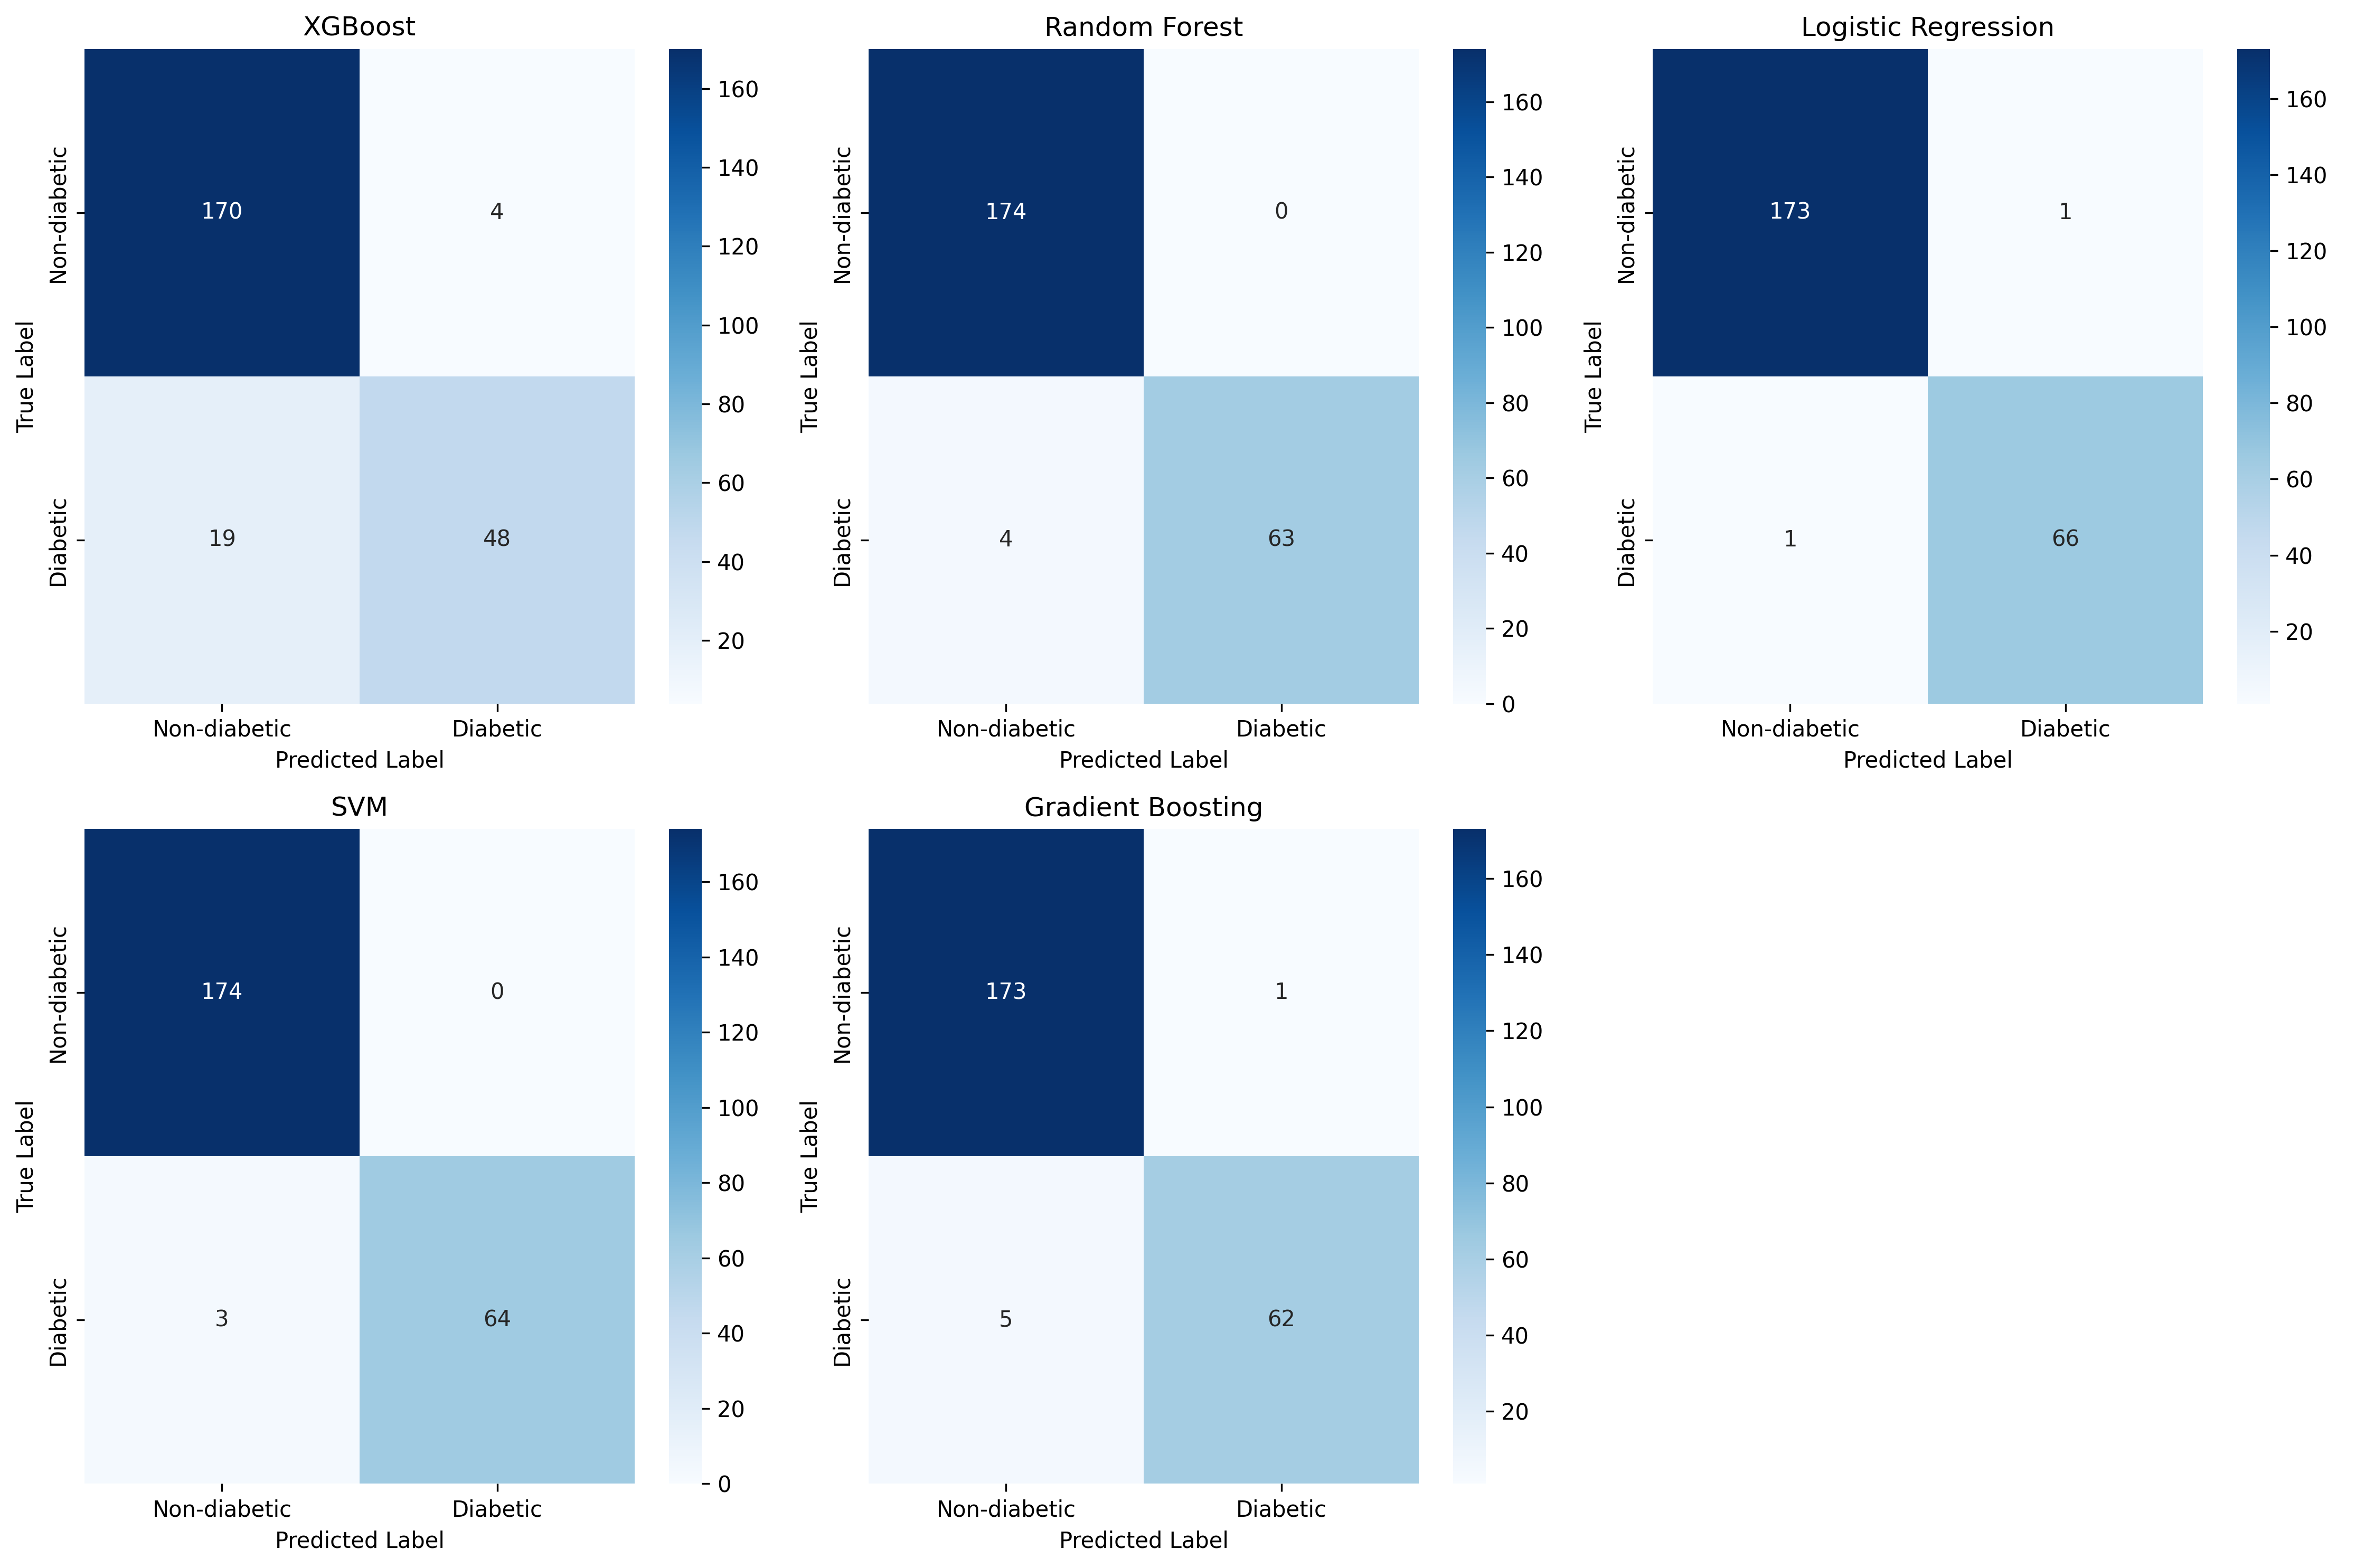

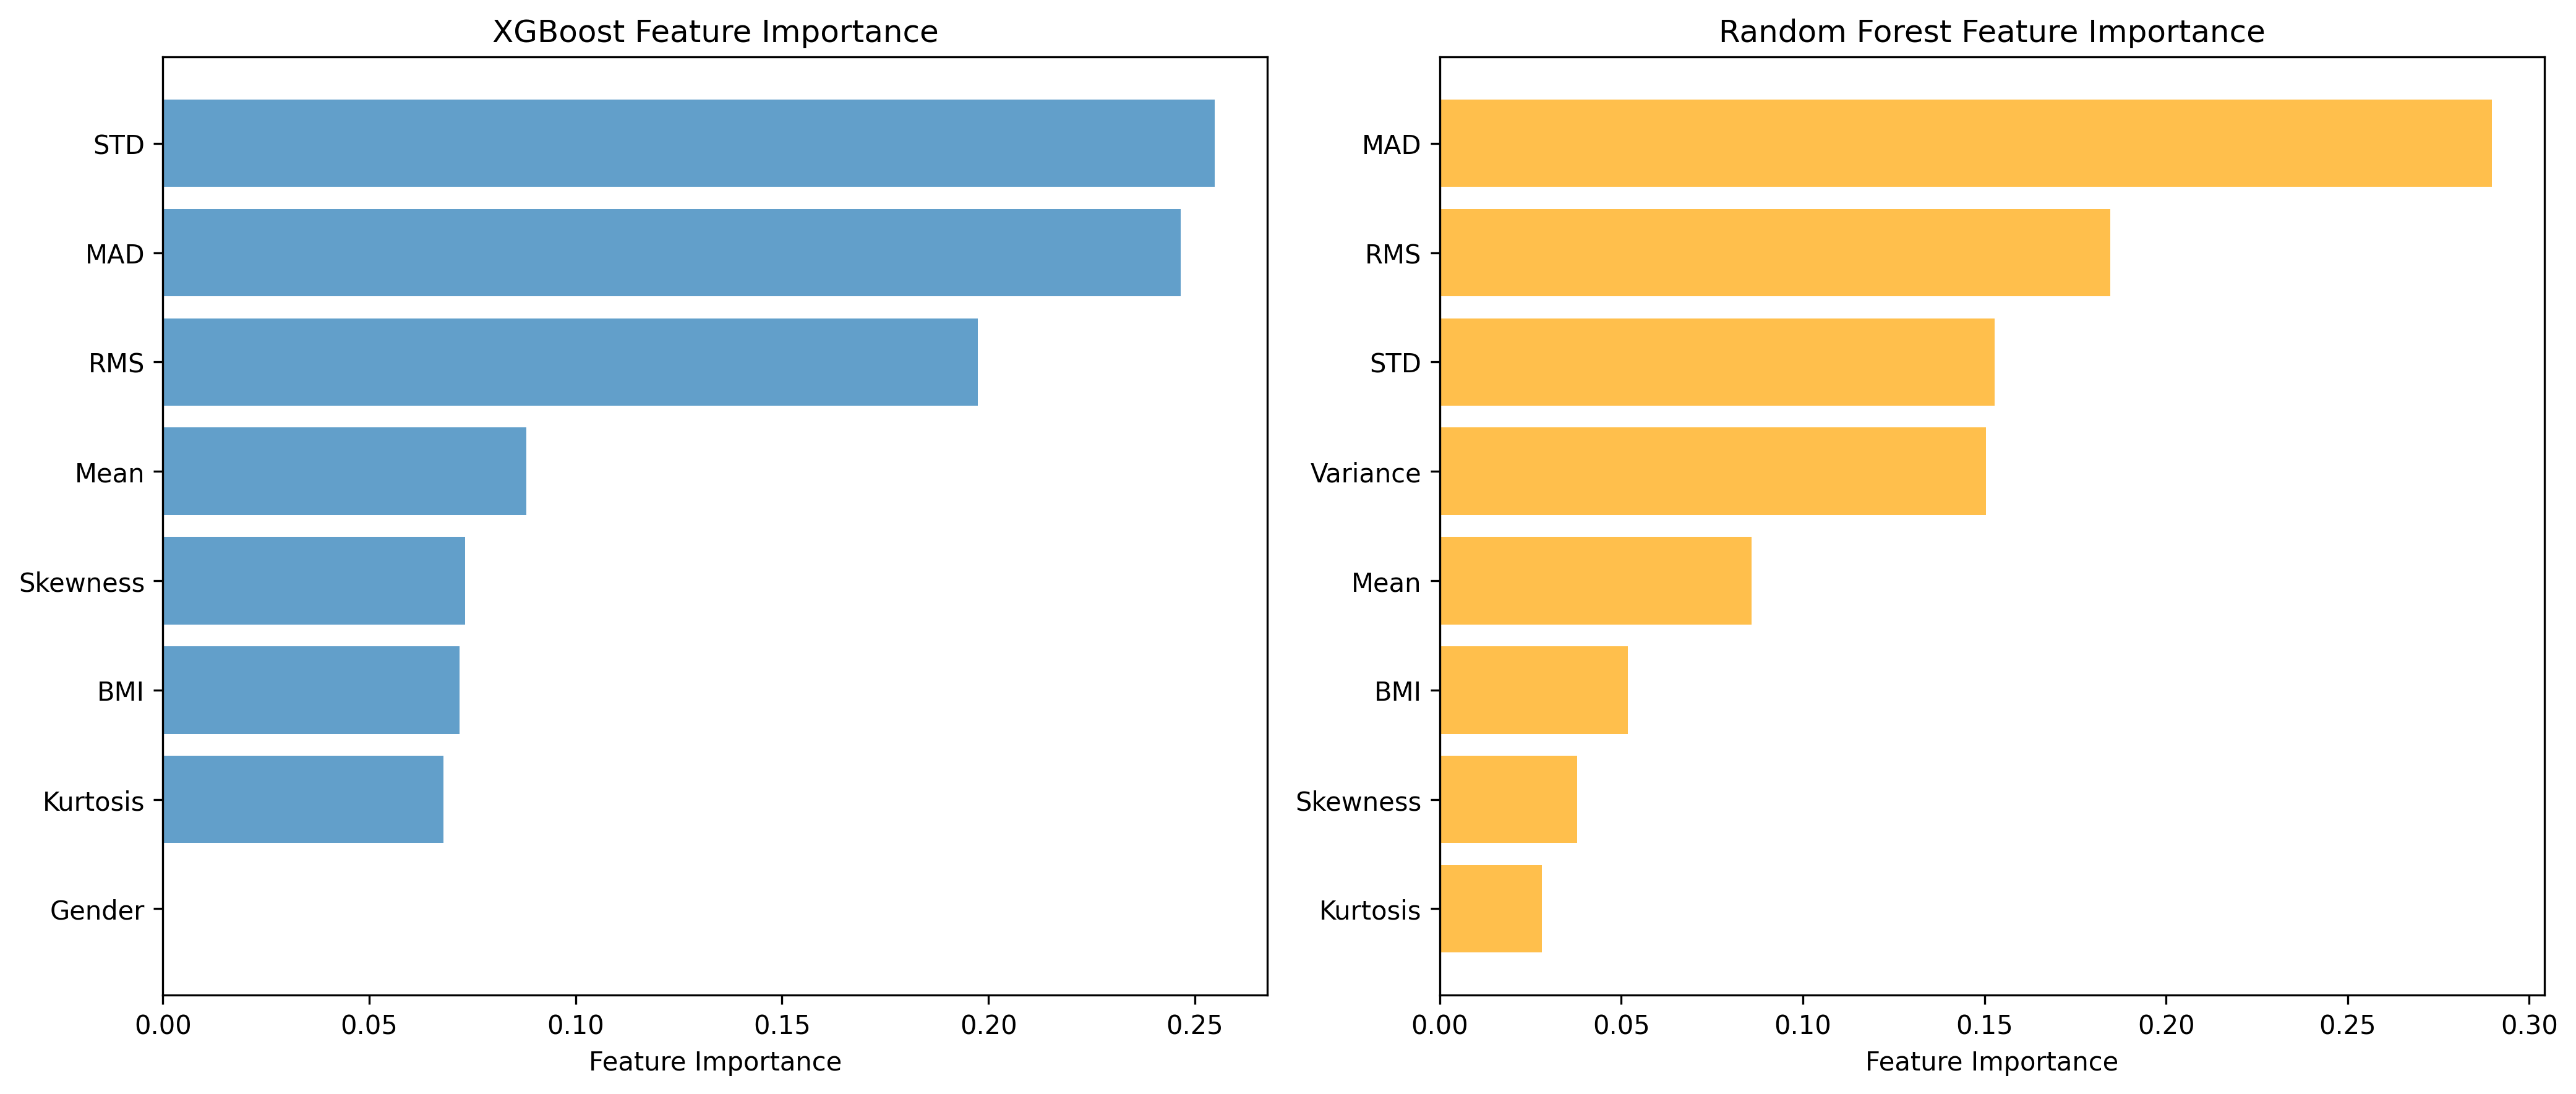


Best Model: Logistic Regression
Accuracy: 99.17%

Generated files:
  - figure1_dataset_distribution.png
  - figure2_correlation_matrix.png
  - figure3_model_comparison.png
  - figure4_roc_curves.png
  - figure5_confusion_matrices.png
  - figure6_feature_importance.png
  - table1_performance_metrics.csv


In [31]:
# Cell 8: Run Pipeline
if __name__ == "__main__":
    pipeline, results = main()


STARTING VALIDATION

VALIDATION REPORT

DATA QUALITY ANALYSIS

1. Sample Size: 241 samples, 10 features (ratio: 24.1)
2. Class Balance: 174 vs 67 (ratio: 2.60:1)
3. Multicollinearity: 3 feature pairs with r > 0.95

OVERFITTING ANALYSIS

Train: 192 samples | Test: 49 samples

XGBoost:
  Train: 94.27% | Test: 87.76% | Gap: 6.52%
Random Forest:
  Train: 100.00% | Test: 97.96% | Gap: 2.04%
Logistic Regression:
  Train: 100.00% | Test: 97.96% | Gap: 2.04%
SVM:
  Train: 100.00% | Test: 100.00% | Gap: 0.00%
Gradient Boosting:
  Train: 100.00% | Test: 97.96% | Gap: 2.04%

GENERATING LEARNING CURVES

Saved: validation_learning_curves.png


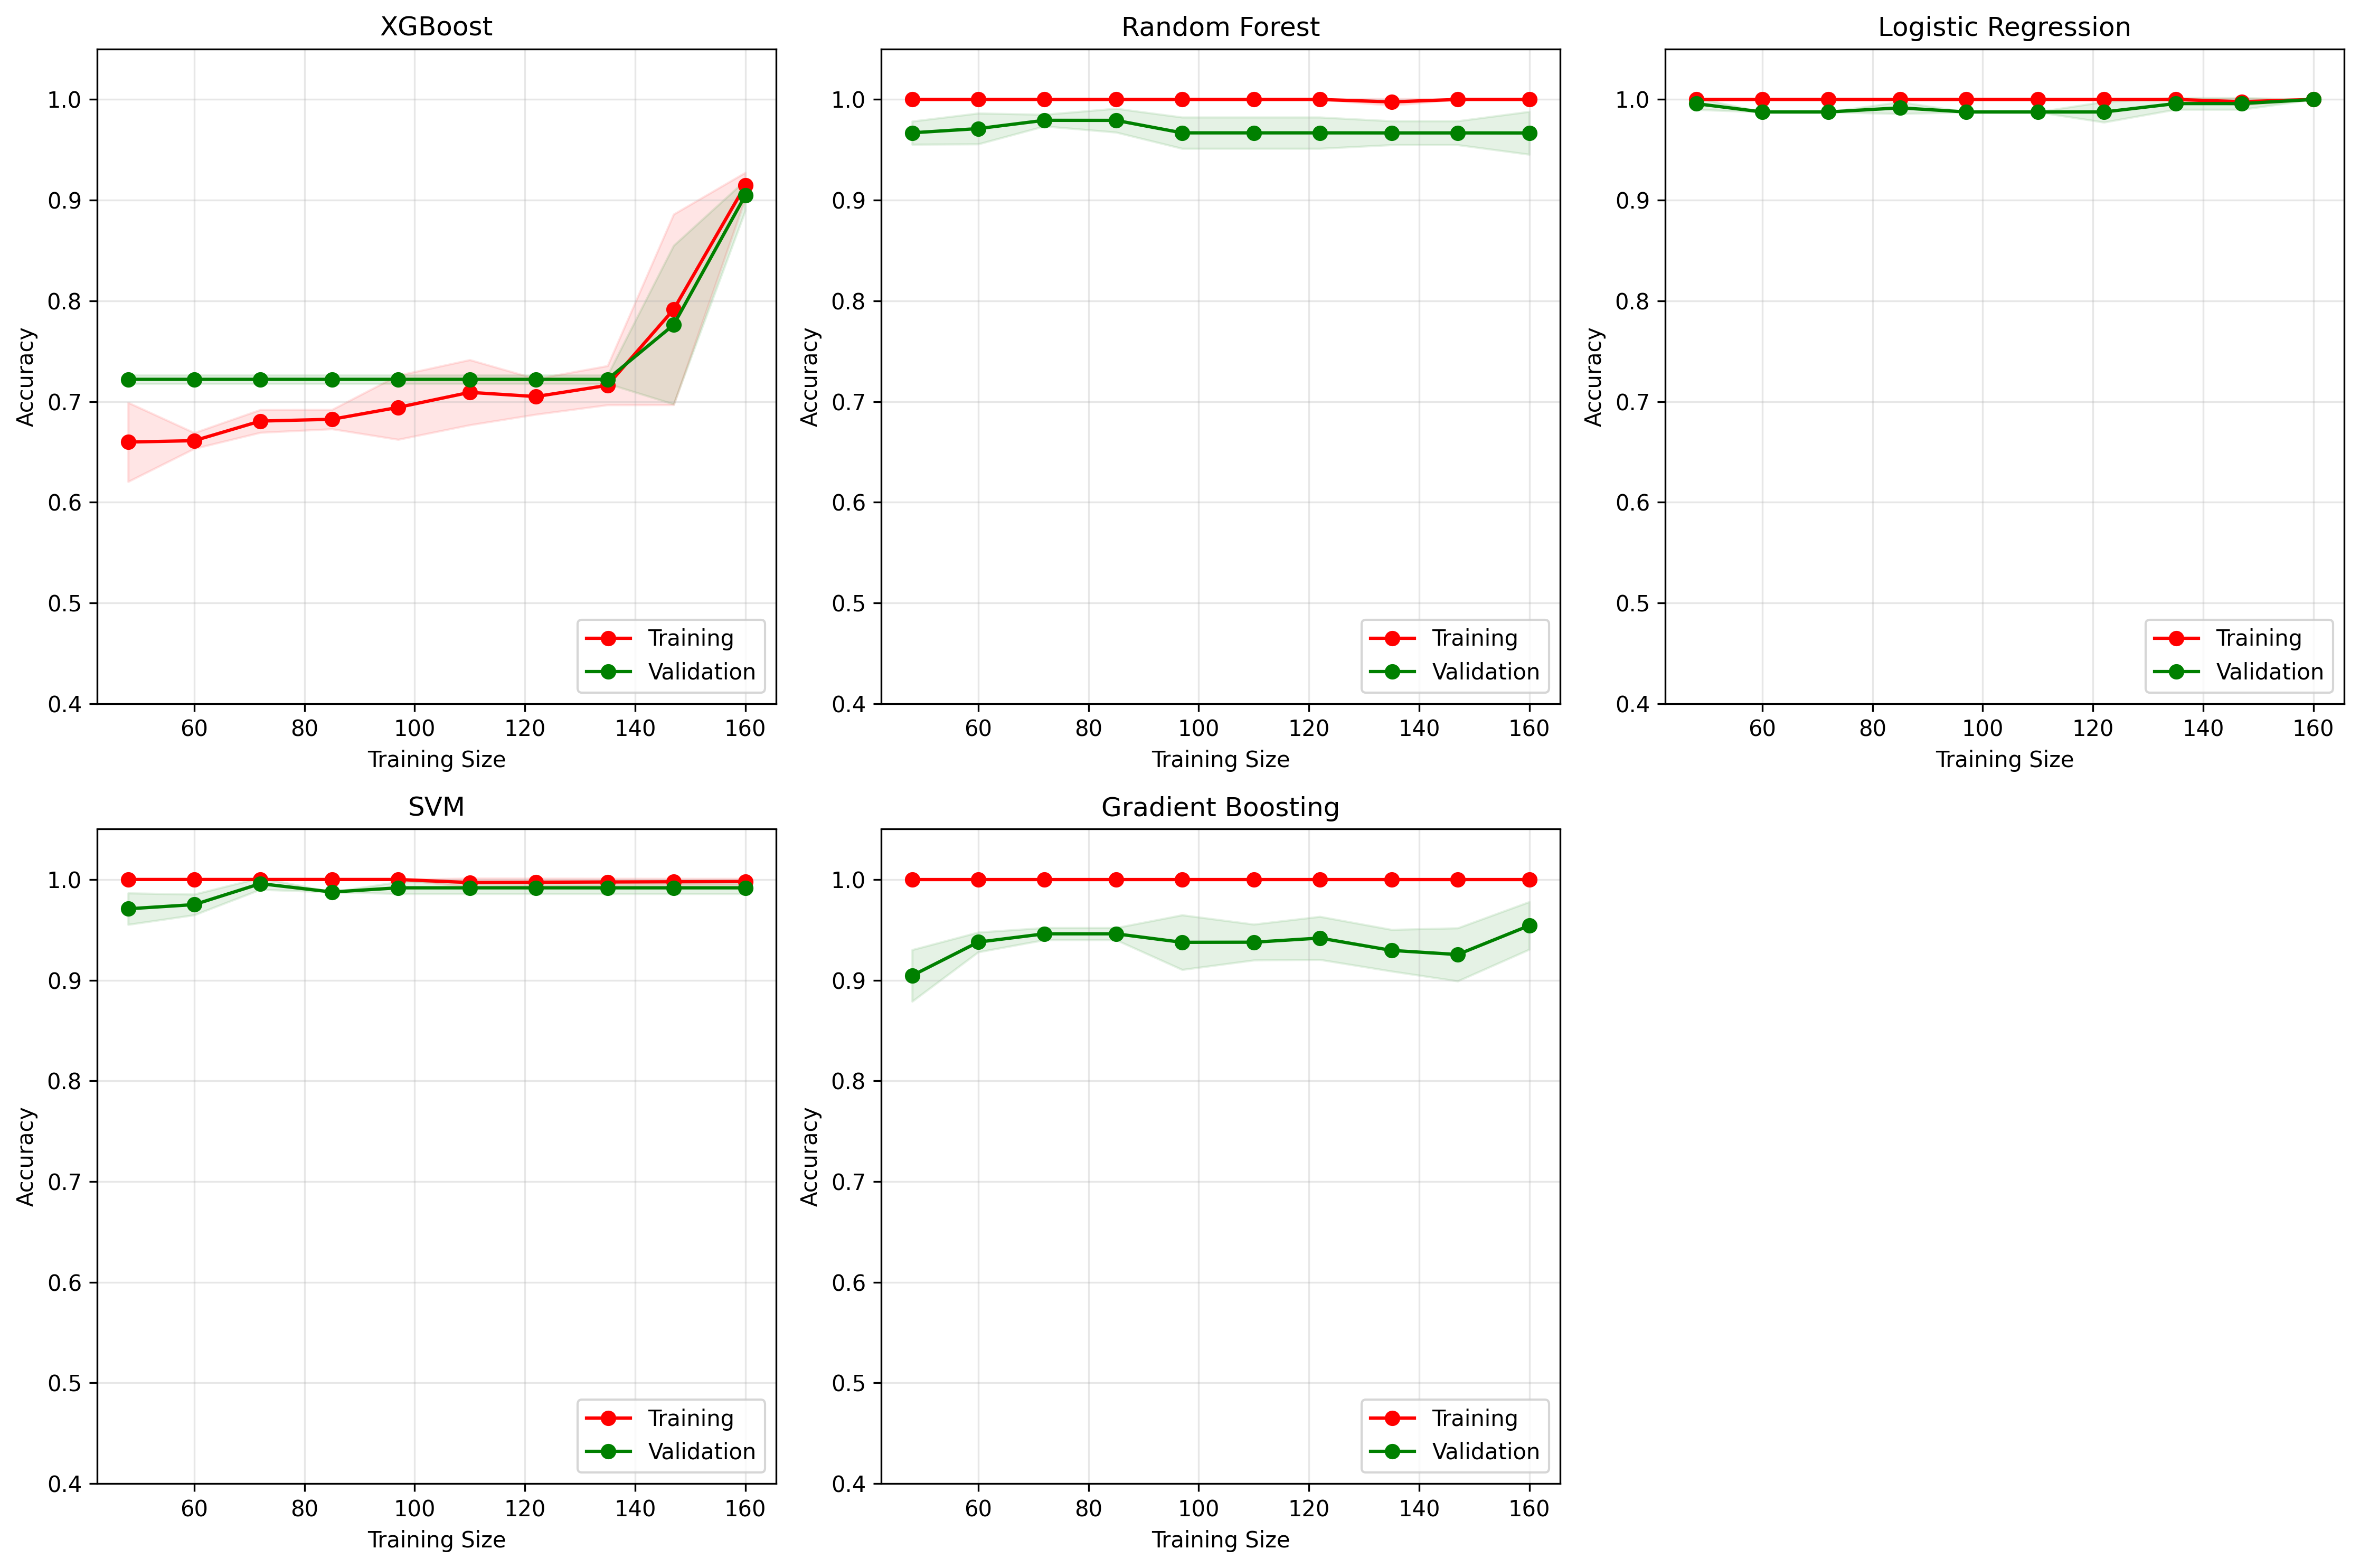


SUMMARY
Found 1 issues:
  1. High feature correlation detected


In [32]:
# ============================================================================
# Cell 9: Validation Checker
from sklearn.model_selection import learning_curve, train_test_split

class ModelValidationChecker:
    def __init__(self, X, y, models, feature_names):
        self.X = X
        self.y = y
        self.models = models
        self.feature_names = feature_names

    def check_data_quality(self):
        print("\nDATA QUALITY ANALYSIS")
        print("="*80)
        issues = []

        n_samples = len(self.y)
        n_features = self.X.shape[1]
        ratio = n_samples / n_features

        print(f"\n1. Sample Size: {n_samples} samples, {n_features} features (ratio: {ratio:.1f})")
        if ratio < 20:
            issues.append(f"Sample-to-feature ratio: {ratio:.1f} (recommended: 20+)")

        class_0 = np.sum(self.y == 0)
        class_1 = np.sum(self.y == 1)
        imbalance_ratio = max(class_0, class_1) / min(class_0, class_1)

        print(f"2. Class Balance: {class_0} vs {class_1} (ratio: {imbalance_ratio:.2f}:1)")
        if imbalance_ratio > 3:
            issues.append(f"Class imbalance: {imbalance_ratio:.2f}:1")

        correlation_matrix = np.corrcoef(self.X.T)
        np.fill_diagonal(correlation_matrix, 0)
        high_corr = np.where(np.abs(correlation_matrix) > 0.95)

        if len(high_corr[0]) > 0:
            print(f"3. Multicollinearity: {len(high_corr[0])//2} feature pairs with r > 0.95")
            issues.append("High feature correlation detected")
        else:
            print("3. Multicollinearity: None detected")

        return issues

    def check_overfitting(self):
        print("\nOVERFITTING ANALYSIS")
        print("="*80)

        issues = []
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(self.X)
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, self.y, test_size=0.2, random_state=42, stratify=self.y
        )

        print(f"\nTrain: {len(y_train)} samples | Test: {len(y_test)} samples\n")

        for model_name, model in self.models.items():
            model.fit(X_train, y_train)
            train_acc = accuracy_score(y_train, model.predict(X_train))
            test_acc = accuracy_score(y_test, model.predict(X_test))
            gap = train_acc - test_acc

            print(f"{model_name}:")
            print(f"  Train: {train_acc*100:.2f}% | Test: {test_acc*100:.2f}% | Gap: {gap*100:.2f}%")

            if gap > 0.10:
                issues.append(f"{model_name}: Train-test gap = {gap*100:.1f}%")

        return issues

    def plot_learning_curves(self):
        print("\nGENERATING LEARNING CURVES")
        print("="*80)

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(self.X)

        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()

        for idx, (model_name, model) in enumerate(list(self.models.items())[:6]):
            train_sizes = np.linspace(0.3, 1.0, 10)
            train_sizes_abs, train_scores, val_scores = learning_curve(
                model, X_scaled, self.y, train_sizes=train_sizes,
                cv=3, scoring='accuracy', random_state=42, n_jobs=-1
            )

            train_mean = np.mean(train_scores, axis=1)
            train_std = np.std(train_scores, axis=1)
            val_mean = np.mean(val_scores, axis=1)
            val_std = np.std(val_scores, axis=1)

            axes[idx].plot(train_sizes_abs, train_mean, 'o-', color='r', label='Training')
            axes[idx].plot(train_sizes_abs, val_mean, 'o-', color='g', label='Validation')
            axes[idx].fill_between(train_sizes_abs, train_mean - train_std,
                                   train_mean + train_std, alpha=0.1, color='r')
            axes[idx].fill_between(train_sizes_abs, val_mean - val_std,
                                   val_mean + val_std, alpha=0.1, color='g')

            axes[idx].set_xlabel('Training Size')
            axes[idx].set_ylabel('Accuracy')
            axes[idx].set_title(f'{model_name}')
            axes[idx].legend(loc='lower right')
            axes[idx].grid(True, alpha=0.3)
            axes[idx].set_ylim([0.4, 1.05])

        if len(self.models) == 5:
            axes[5].axis('off')

        plt.tight_layout()
        plt.savefig('validation_learning_curves.png', dpi=300, bbox_inches='tight')
        print("\nSaved: validation_learning_curves.png")
        plt.show()

    def generate_report(self):
        print("\nVALIDATION REPORT")
        print("="*80)

        all_issues = []
        all_issues.extend(self.check_data_quality())
        all_issues.extend(self.check_overfitting())
        self.plot_learning_curves()

        print("\nSUMMARY")
        print("="*80)
        if len(all_issues) == 0:
            print("✓ No major validation issues detected")
        else:
            print(f"Found {len(all_issues)} issues:")
            for i, issue in enumerate(all_issues, 1):
                print(f"  {i}. {issue}")

def run_validation():
    print("\nSTARTING VALIDATION")
    print("="*80)

    validator = ModelValidationChecker(
        pipeline.features,
        pipeline.labels,
        create_ml_models(),
        pipeline.feature_names
    )
    validator.generate_report()

# Run validation automatically after main pipeline
run_validation()